In [1]:
import os, json, sys, time, random
import numpy as np
import torch
from  easydict import EasyDict
from math import floor
from easydict import EasyDict

from steves_utils.vanilla_train_eval_test_jig import  Vanilla_Train_Eval_Test_Jig

from steves_utils.torch_utils import get_dataset_metrics, independent_accuracy_assesment
from steves_models.configurable_vanilla import Configurable_Vanilla
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.lazy_map import Lazy_Map
from steves_utils.sequence_aggregator import Sequence_Aggregator

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.cnn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.torch_utils import (
    confusion_by_domain_over_dataloader,
    independent_accuracy_assesment
)

from steves_utils.utils_v2 import (
    per_domain_accuracy_from_confusion,
    get_datasets_base_path
)

# from steves_utils.ptn_do_report import TBD

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "dataset_seed",
    "seed",
    "labels",
    "domains_target",
    "domains_source",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "batch_size",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "normalize_source",
    "normalize_target",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "pickle_name_source",
    "pickle_name_target",
    "torch_default_dtype",
}

In [3]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_SERIAL_NUMBERS,
    ALL_DISTANCES_FEET_NARROWED,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "MANUAL CORES CNN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["dataset_seed"] = 1337
standalone_parameters["seed"] = 1337
standalone_parameters["labels"] = ALL_SERIAL_NUMBERS

standalone_parameters["domains_source"] = [8,32,50]
standalone_parameters["domains_target"] = [14,20,26,38,44,]

standalone_parameters["num_examples_per_domain_per_label_source"]=-1
standalone_parameters["num_examples_per_domain_per_label_target"]=-1

standalone_parameters["pickle_name_source"] = "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"
standalone_parameters["pickle_name_target"] = "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"

standalone_parameters["torch_default_dtype"] = "torch.float32" 

standalone_parameters["batch_size"]=128

standalone_parameters["n_epoch"] = 3

standalone_parameters["patience"] = 10

standalone_parameters["criteria_for_best"] = "target_accuracy"
standalone_parameters["normalize_source"] = False
standalone_parameters["normalize_target"] = False

standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": len(standalone_parameters["labels"])}},
]

standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

In [4]:
# Parameters
parameters = {
    "experiment_name": "cnn_3:oracle.run1.framed-oracle.run2.framed",
    "labels": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "domains_source": [8, 32, 50, 14, 20, 26, 38, 44],
    "domains_target": [8, 32, 50, 14, 20, 26, 38, 44],
    "pickle_name_source": "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
    "pickle_name_target": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 128,
    "normalize_source": False,
    "normalize_target": False,
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 16}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "dataset_seed": 500,
    "seed": 500,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
def wrap_in_dataloader(p, ds):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=p.batch_size,
        shuffle=True,
        num_workers=1,
        persistent_workers=True,
        prefetch_factor=50,
        pin_memory=True
    )

taf_source = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_source),
    seed=p.dataset_seed
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()


taf_target = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_target),
    seed=p.dataset_seed
)
train_original_target, val_original_target, test_original_target = \
    taf_target.get_train(), taf_target.get_val(), taf_target.get_test()


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Map. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[:2] # Strip the tuple to just (x,y)


train_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_source, transform_lambda)
)
val_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_source, transform_lambda)
)
test_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_source, transform_lambda)
)

train_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_target, transform_lambda)
)
val_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_target, transform_lambda)
)
test_processed_target  = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_target, transform_lambda)
)



datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
ep = next(iter(test_processed_target))
ep[0].dtype

torch.float32

In [12]:
model = Configurable_Vanilla(
    x_net=x_net,
    label_loss_object=torch.nn.NLLLoss(),
    learning_rate=p.lr
)

In [13]:
jig = Vanilla_Train_Eval_Test_Jig(
    model=model,
    path_to_best_model=p.BEST_MODEL_PATH,
    device=p.device,
    label_loss_object=torch.nn.NLLLoss(),
)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    patience=p.patience,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    criteria_for_best=p.criteria_for_best
)

epoch: 1, [batch: 1 / 1400], examples_per_second: 615.0728, train_label_loss: 2.8238, 


epoch: 1, [batch: 140 / 1400], examples_per_second: 10635.9058, train_label_loss: 2.7253, 


epoch: 1, [batch: 280 / 1400], examples_per_second: 10762.4979, train_label_loss: 2.5891, 


epoch: 1, [batch: 420 / 1400], examples_per_second: 10617.5641, train_label_loss: 2.5074, 


epoch: 1, [batch: 560 / 1400], examples_per_second: 10720.8698, train_label_loss: 2.3486, 


epoch: 1, [batch: 700 / 1400], examples_per_second: 10651.1832, train_label_loss: 2.2373, 


epoch: 1, [batch: 840 / 1400], examples_per_second: 10649.2531, train_label_loss: 2.0611, 


epoch: 1, [batch: 980 / 1400], examples_per_second: 10633.2985, train_label_loss: 1.8504, 


epoch: 1, [batch: 1120 / 1400], examples_per_second: 10631.1433, train_label_loss: 1.8777, 


epoch: 1, [batch: 1260 / 1400], examples_per_second: 10746.2670, train_label_loss: 1.5474, 


epoch: 1, source_val_acc_label: 0.5688, source_val_label_loss: 1.5241, target_val_acc_label: 0.5262, target_val_label_loss: 1.5864, 


New best
epoch: 2, [batch: 1 / 1400], examples_per_second: 47.4326, train_label_loss: 1.5158, 


epoch: 2, [batch: 140 / 1400], examples_per_second: 10633.3794, train_label_loss: 1.4071, 


epoch: 2, [batch: 280 / 1400], examples_per_second: 10697.0674, train_label_loss: 1.2934, 


epoch: 2, [batch: 420 / 1400], examples_per_second: 10700.5564, train_label_loss: 1.3142, 


epoch: 2, [batch: 560 / 1400], examples_per_second: 10737.1145, train_label_loss: 1.1657, 


epoch: 2, [batch: 700 / 1400], examples_per_second: 10664.9998, train_label_loss: 1.1772, 


epoch: 2, [batch: 840 / 1400], examples_per_second: 10613.6794, train_label_loss: 0.9354, 


epoch: 2, [batch: 980 / 1400], examples_per_second: 10670.3308, train_label_loss: 0.9201, 


epoch: 2, [batch: 1120 / 1400], examples_per_second: 10451.2685, train_label_loss: 0.8622, 


epoch: 2, [batch: 1260 / 1400], examples_per_second: 10690.1464, train_label_loss: 0.8427, 


epoch: 2, source_val_acc_label: 0.8201, source_val_label_loss: 0.7253, target_val_acc_label: 0.7448, target_val_label_loss: 0.8876, 


New best
epoch: 3, [batch: 1 / 1400], examples_per_second: 56.1537, train_label_loss: 0.6666, 


epoch: 3, [batch: 140 / 1400], examples_per_second: 10479.0427, train_label_loss: 0.6982, 


epoch: 3, [batch: 280 / 1400], examples_per_second: 10367.7173, train_label_loss: 0.6388, 


epoch: 3, [batch: 420 / 1400], examples_per_second: 10778.4534, train_label_loss: 0.5685, 


epoch: 3, [batch: 560 / 1400], examples_per_second: 10677.9770, train_label_loss: 0.6146, 


epoch: 3, [batch: 700 / 1400], examples_per_second: 10651.4700, train_label_loss: 0.5173, 


epoch: 3, [batch: 840 / 1400], examples_per_second: 10593.7563, train_label_loss: 0.7165, 


epoch: 3, [batch: 980 / 1400], examples_per_second: 10591.8424, train_label_loss: 0.6045, 


epoch: 3, [batch: 1120 / 1400], examples_per_second: 10065.9530, train_label_loss: 0.4305, 


epoch: 3, [batch: 1260 / 1400], examples_per_second: 10654.9504, train_label_loss: 0.4352, 


epoch: 3, source_val_acc_label: 0.8893, source_val_label_loss: 0.4449, target_val_acc_label: 0.8117, target_val_label_loss: 0.6584, 


New best
epoch: 4, [batch: 1 / 1400], examples_per_second: 56.4021, train_label_loss: 0.4867, 


epoch: 4, [batch: 140 / 1400], examples_per_second: 10485.4256, train_label_loss: 0.4713, 


epoch: 4, [batch: 280 / 1400], examples_per_second: 10719.5595, train_label_loss: 0.4915, 


epoch: 4, [batch: 420 / 1400], examples_per_second: 10772.7529, train_label_loss: 0.5104, 


epoch: 4, [batch: 560 / 1400], examples_per_second: 10533.6168, train_label_loss: 0.4135, 


epoch: 4, [batch: 700 / 1400], examples_per_second: 10574.4672, train_label_loss: 0.5086, 


epoch: 4, [batch: 840 / 1400], examples_per_second: 10630.1118, train_label_loss: 0.8058, 


epoch: 4, [batch: 980 / 1400], examples_per_second: 10689.4972, train_label_loss: 0.3214, 


epoch: 4, [batch: 1120 / 1400], examples_per_second: 10562.9337, train_label_loss: 0.3317, 


epoch: 4, [batch: 1260 / 1400], examples_per_second: 10602.3414, train_label_loss: 0.3505, 


epoch: 4, source_val_acc_label: 0.8949, source_val_label_loss: 0.3442, target_val_acc_label: 0.7988, target_val_label_loss: 0.6044, 


epoch: 5, [batch: 1 / 1400], examples_per_second: 58.4863, train_label_loss: 0.2976, 


epoch: 5, [batch: 140 / 1400], examples_per_second: 10629.4536, train_label_loss: 0.2726, 


epoch: 5, [batch: 280 / 1400], examples_per_second: 10582.9286, train_label_loss: 0.3128, 


epoch: 5, [batch: 420 / 1400], examples_per_second: 10753.6240, train_label_loss: 0.2488, 


epoch: 5, [batch: 560 / 1400], examples_per_second: 10759.3797, train_label_loss: 0.2420, 


epoch: 5, [batch: 700 / 1400], examples_per_second: 10743.0768, train_label_loss: 0.2944, 


epoch: 5, [batch: 840 / 1400], examples_per_second: 10742.5639, train_label_loss: 0.2982, 


epoch: 5, [batch: 980 / 1400], examples_per_second: 10833.6817, train_label_loss: 0.2654, 


epoch: 5, [batch: 1120 / 1400], examples_per_second: 10697.2836, train_label_loss: 0.2235, 


epoch: 5, [batch: 1260 / 1400], examples_per_second: 10677.8617, train_label_loss: 0.2879, 


epoch: 5, source_val_acc_label: 0.9278, source_val_label_loss: 0.2641, target_val_acc_label: 0.8369, target_val_label_loss: 0.5947, 


New best
epoch: 6, [batch: 1 / 1400], examples_per_second: 59.6141, train_label_loss: 0.1826, 


epoch: 6, [batch: 140 / 1400], examples_per_second: 11711.8289, train_label_loss: 0.1344, 


epoch: 6, [batch: 280 / 1400], examples_per_second: 11780.7427, train_label_loss: 0.1758, 


epoch: 6, [batch: 420 / 1400], examples_per_second: 11609.6173, train_label_loss: 0.2343, 


epoch: 6, [batch: 560 / 1400], examples_per_second: 11741.4717, train_label_loss: 0.1690, 


epoch: 6, [batch: 700 / 1400], examples_per_second: 11696.1773, train_label_loss: 0.3861, 


epoch: 6, [batch: 840 / 1400], examples_per_second: 11786.4252, train_label_loss: 0.3042, 


epoch: 6, [batch: 980 / 1400], examples_per_second: 11783.5667, train_label_loss: 0.2725, 


epoch: 6, [batch: 1120 / 1400], examples_per_second: 11816.5494, train_label_loss: 0.1968, 


epoch: 6, [batch: 1260 / 1400], examples_per_second: 11810.8601, train_label_loss: 0.1990, 


epoch: 6, source_val_acc_label: 0.9369, source_val_label_loss: 0.2105, target_val_acc_label: 0.8484, target_val_label_loss: 0.5166, 


New best
epoch: 7, [batch: 1 / 1400], examples_per_second: 64.2601, train_label_loss: 0.1671, 


epoch: 7, [batch: 140 / 1400], examples_per_second: 11785.6547, train_label_loss: 0.1758, 


epoch: 7, [batch: 280 / 1400], examples_per_second: 11731.9471, train_label_loss: 0.2493, 


epoch: 7, [batch: 420 / 1400], examples_per_second: 11756.5793, train_label_loss: 0.2120, 


epoch: 7, [batch: 560 / 1400], examples_per_second: 11810.9621, train_label_loss: 0.2340, 


epoch: 7, [batch: 700 / 1400], examples_per_second: 11848.0997, train_label_loss: 0.3020, 


epoch: 7, [batch: 840 / 1400], examples_per_second: 11803.2852, train_label_loss: 0.2544, 


epoch: 7, [batch: 980 / 1400], examples_per_second: 11817.9150, train_label_loss: 0.1597, 


epoch: 7, [batch: 1120 / 1400], examples_per_second: 11754.6855, train_label_loss: 0.1689, 


epoch: 7, [batch: 1260 / 1400], examples_per_second: 11739.1153, train_label_loss: 0.1506, 


epoch: 7, source_val_acc_label: 0.9466, source_val_label_loss: 0.1826, target_val_acc_label: 0.8494, target_val_label_loss: 0.4988, 


New best
epoch: 8, [batch: 1 / 1400], examples_per_second: 64.0289, train_label_loss: 0.1751, 


epoch: 8, [batch: 140 / 1400], examples_per_second: 12159.1481, train_label_loss: 0.2673, 


epoch: 8, [batch: 280 / 1400], examples_per_second: 11834.4758, train_label_loss: 0.2602, 


epoch: 8, [batch: 420 / 1400], examples_per_second: 11867.3530, train_label_loss: 0.1994, 


epoch: 8, [batch: 560 / 1400], examples_per_second: 11834.2373, train_label_loss: 0.2031, 


epoch: 8, [batch: 700 / 1400], examples_per_second: 11500.2935, train_label_loss: 0.1664, 


epoch: 8, [batch: 840 / 1400], examples_per_second: 11756.9526, train_label_loss: 0.4065, 


epoch: 8, [batch: 980 / 1400], examples_per_second: 11703.4876, train_label_loss: 0.1463, 


epoch: 8, [batch: 1120 / 1400], examples_per_second: 11845.2485, train_label_loss: 0.1686, 


epoch: 8, [batch: 1260 / 1400], examples_per_second: 11768.4652, train_label_loss: 0.1536, 


epoch: 8, source_val_acc_label: 0.9464, source_val_label_loss: 0.2182, target_val_acc_label: 0.8479, target_val_label_loss: 0.5446, 


epoch: 9, [batch: 1 / 1400], examples_per_second: 65.7169, train_label_loss: 0.1710, 


epoch: 9, [batch: 140 / 1400], examples_per_second: 11537.1253, train_label_loss: 0.1457, 


epoch: 9, [batch: 280 / 1400], examples_per_second: 11823.6112, train_label_loss: 0.1656, 


epoch: 9, [batch: 420 / 1400], examples_per_second: 11761.7250, train_label_loss: 0.1863, 


epoch: 9, [batch: 560 / 1400], examples_per_second: 11827.3899, train_label_loss: 0.1508, 


epoch: 9, [batch: 700 / 1400], examples_per_second: 11782.0151, train_label_loss: 0.1484, 


epoch: 9, [batch: 840 / 1400], examples_per_second: 11800.7371, train_label_loss: 0.2449, 


epoch: 9, [batch: 980 / 1400], examples_per_second: 11830.5864, train_label_loss: 0.1368, 


epoch: 9, [batch: 1120 / 1400], examples_per_second: 11790.9608, train_label_loss: 0.1692, 


epoch: 9, [batch: 1260 / 1400], examples_per_second: 11798.1772, train_label_loss: 0.1695, 


epoch: 9, source_val_acc_label: 0.9416, source_val_label_loss: 0.1914, target_val_acc_label: 0.8425, target_val_label_loss: 0.7790, 


epoch: 10, [batch: 1 / 1400], examples_per_second: 66.1255, train_label_loss: 0.1079, 


epoch: 10, [batch: 140 / 1400], examples_per_second: 12705.8939, train_label_loss: 0.1169, 


epoch: 10, [batch: 280 / 1400], examples_per_second: 12547.1387, train_label_loss: 0.1365, 


epoch: 10, [batch: 420 / 1400], examples_per_second: 12693.0233, train_label_loss: 0.1430, 


epoch: 10, [batch: 560 / 1400], examples_per_second: 11615.7444, train_label_loss: 0.1717, 


epoch: 10, [batch: 700 / 1400], examples_per_second: 10758.0891, train_label_loss: 0.1716, 


epoch: 10, [batch: 840 / 1400], examples_per_second: 10746.9892, train_label_loss: 0.1258, 


epoch: 10, [batch: 980 / 1400], examples_per_second: 10703.9897, train_label_loss: 0.1043, 


epoch: 10, [batch: 1120 / 1400], examples_per_second: 10709.2041, train_label_loss: 0.1415, 


epoch: 10, [batch: 1260 / 1400], examples_per_second: 10769.3849, train_label_loss: 0.1608, 


epoch: 10, source_val_acc_label: 0.9422, source_val_label_loss: 0.1740, target_val_acc_label: 0.8414, target_val_label_loss: 0.6380, 


epoch: 11, [batch: 1 / 1400], examples_per_second: 64.5204, train_label_loss: 0.2203, 


epoch: 11, [batch: 140 / 1400], examples_per_second: 11725.8777, train_label_loss: 0.1942, 


epoch: 11, [batch: 280 / 1400], examples_per_second: 11559.5411, train_label_loss: 0.1114, 


epoch: 11, [batch: 420 / 1400], examples_per_second: 11788.5400, train_label_loss: 0.1668, 


epoch: 11, [batch: 560 / 1400], examples_per_second: 11797.7216, train_label_loss: 0.1704, 


epoch: 11, [batch: 700 / 1400], examples_per_second: 11626.6583, train_label_loss: 0.1367, 


epoch: 11, [batch: 840 / 1400], examples_per_second: 11820.5189, train_label_loss: 0.1054, 


epoch: 11, [batch: 980 / 1400], examples_per_second: 11833.6765, train_label_loss: 0.0864, 


epoch: 11, [batch: 1120 / 1400], examples_per_second: 11811.6303, train_label_loss: 0.1256, 


epoch: 11, [batch: 1260 / 1400], examples_per_second: 11760.9521, train_label_loss: 0.1280, 


epoch: 11, source_val_acc_label: 0.9486, source_val_label_loss: 0.2314, target_val_acc_label: 0.8528, target_val_label_loss: 0.8854, 


New best
epoch: 12, [batch: 1 / 1400], examples_per_second: 64.3295, train_label_loss: 0.1162, 


epoch: 12, [batch: 140 / 1400], examples_per_second: 11610.2050, train_label_loss: 0.1247, 


epoch: 12, [batch: 280 / 1400], examples_per_second: 11799.6571, train_label_loss: 0.2892, 


epoch: 12, [batch: 420 / 1400], examples_per_second: 11644.6333, train_label_loss: 0.1737, 


epoch: 12, [batch: 560 / 1400], examples_per_second: 11564.8040, train_label_loss: 0.0812, 


epoch: 12, [batch: 700 / 1400], examples_per_second: 11733.5405, train_label_loss: 0.0849, 


epoch: 12, [batch: 840 / 1400], examples_per_second: 11782.7520, train_label_loss: 0.1508, 


epoch: 12, [batch: 980 / 1400], examples_per_second: 11784.5311, train_label_loss: 0.1715, 


epoch: 12, [batch: 1120 / 1400], examples_per_second: 11825.4919, train_label_loss: 0.0955, 


epoch: 12, [batch: 1260 / 1400], examples_per_second: 11880.0462, train_label_loss: 0.0518, 


epoch: 12, source_val_acc_label: 0.9505, source_val_label_loss: 0.1487, target_val_acc_label: 0.8652, target_val_label_loss: 0.5107, 


New best
epoch: 13, [batch: 1 / 1400], examples_per_second: 66.9092, train_label_loss: 0.1171, 


epoch: 13, [batch: 140 / 1400], examples_per_second: 11778.0041, train_label_loss: 0.1099, 


epoch: 13, [batch: 280 / 1400], examples_per_second: 11801.0206, train_label_loss: 0.0666, 


epoch: 13, [batch: 420 / 1400], examples_per_second: 11773.3909, train_label_loss: 0.0718, 


epoch: 13, [batch: 560 / 1400], examples_per_second: 11799.2792, train_label_loss: 0.1064, 


epoch: 13, [batch: 700 / 1400], examples_per_second: 11723.7727, train_label_loss: 0.0700, 


epoch: 13, [batch: 840 / 1400], examples_per_second: 11797.9883, train_label_loss: 0.1011, 


epoch: 13, [batch: 980 / 1400], examples_per_second: 11812.7961, train_label_loss: 0.1577, 


epoch: 13, [batch: 1120 / 1400], examples_per_second: 11786.6119, train_label_loss: 0.1120, 


epoch: 13, [batch: 1260 / 1400], examples_per_second: 11791.1291, train_label_loss: 0.1199, 


epoch: 13, source_val_acc_label: 0.9492, source_val_label_loss: 0.1656, target_val_acc_label: 0.8518, target_val_label_loss: 0.5399, 


epoch: 14, [batch: 1 / 1400], examples_per_second: 65.1367, train_label_loss: 0.1122, 


epoch: 14, [batch: 140 / 1400], examples_per_second: 11803.5823, train_label_loss: 0.1168, 


epoch: 14, [batch: 280 / 1400], examples_per_second: 11743.8163, train_label_loss: 0.1284, 


epoch: 14, [batch: 420 / 1400], examples_per_second: 11758.3118, train_label_loss: 0.1442, 


epoch: 14, [batch: 560 / 1400], examples_per_second: 11782.7539, train_label_loss: 0.0731, 


epoch: 14, [batch: 700 / 1400], examples_per_second: 11796.6699, train_label_loss: 0.0862, 


epoch: 14, [batch: 840 / 1400], examples_per_second: 11785.4291, train_label_loss: 0.0918, 


epoch: 14, [batch: 980 / 1400], examples_per_second: 11853.1838, train_label_loss: 0.0926, 


epoch: 14, [batch: 1120 / 1400], examples_per_second: 11818.4372, train_label_loss: 0.0758, 


epoch: 14, [batch: 1260 / 1400], examples_per_second: 11829.9123, train_label_loss: 0.0907, 


epoch: 14, source_val_acc_label: 0.9519, source_val_label_loss: 0.1656, target_val_acc_label: 0.8598, target_val_label_loss: 0.7722, 


epoch: 15, [batch: 1 / 1400], examples_per_second: 68.1271, train_label_loss: 0.0554, 


epoch: 15, [batch: 140 / 1400], examples_per_second: 12402.6930, train_label_loss: 0.1031, 


epoch: 15, [batch: 280 / 1400], examples_per_second: 12395.2982, train_label_loss: 0.0966, 


epoch: 15, [batch: 420 / 1400], examples_per_second: 11180.2637, train_label_loss: 0.0907, 


epoch: 15, [batch: 560 / 1400], examples_per_second: 10771.8605, train_label_loss: 0.0588, 


epoch: 15, [batch: 700 / 1400], examples_per_second: 10625.7928, train_label_loss: 0.1059, 


epoch: 15, [batch: 840 / 1400], examples_per_second: 10873.8320, train_label_loss: 0.0865, 


epoch: 15, [batch: 980 / 1400], examples_per_second: 10825.6208, train_label_loss: 0.0714, 


epoch: 15, [batch: 1120 / 1400], examples_per_second: 10731.1834, train_label_loss: 0.0742, 


epoch: 15, [batch: 1260 / 1400], examples_per_second: 10461.3638, train_label_loss: 0.0798, 


epoch: 15, source_val_acc_label: 0.9614, source_val_label_loss: 0.1271, target_val_acc_label: 0.8583, target_val_label_loss: 0.7423, 


epoch: 16, [batch: 1 / 1400], examples_per_second: 57.2527, train_label_loss: 0.1054, 


epoch: 16, [batch: 140 / 1400], examples_per_second: 10747.7423, train_label_loss: 0.0877, 


epoch: 16, [batch: 280 / 1400], examples_per_second: 10771.2893, train_label_loss: 0.1606, 


epoch: 16, [batch: 420 / 1400], examples_per_second: 10783.0042, train_label_loss: 0.0810, 


epoch: 16, [batch: 560 / 1400], examples_per_second: 10744.1564, train_label_loss: 0.0680, 


epoch: 16, [batch: 700 / 1400], examples_per_second: 10725.1104, train_label_loss: 0.1092, 


epoch: 16, [batch: 840 / 1400], examples_per_second: 10628.9408, train_label_loss: 0.1860, 


epoch: 16, [batch: 980 / 1400], examples_per_second: 10744.3192, train_label_loss: 0.0640, 


epoch: 16, [batch: 1120 / 1400], examples_per_second: 10744.2055, train_label_loss: 0.0736, 


epoch: 16, [batch: 1260 / 1400], examples_per_second: 10708.7784, train_label_loss: 0.0739, 


epoch: 16, source_val_acc_label: 0.9590, source_val_label_loss: 0.1266, target_val_acc_label: 0.8598, target_val_label_loss: 0.4933, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = wrap_in_dataloader(p, Sequence_Aggregator((datasets.source.original.val, datasets.target.original.val)))

confusion = confusion_by_domain_over_dataloader(model, p.device, val_dl, forward_uses_domain=False)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

###################################
# Write out the results
###################################

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": p,
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "cnn"),
}

<AxesSubplot:title={'center':'Source Train Label Loss vs Source Val Label Loss'}, xlabel='Epoch'>

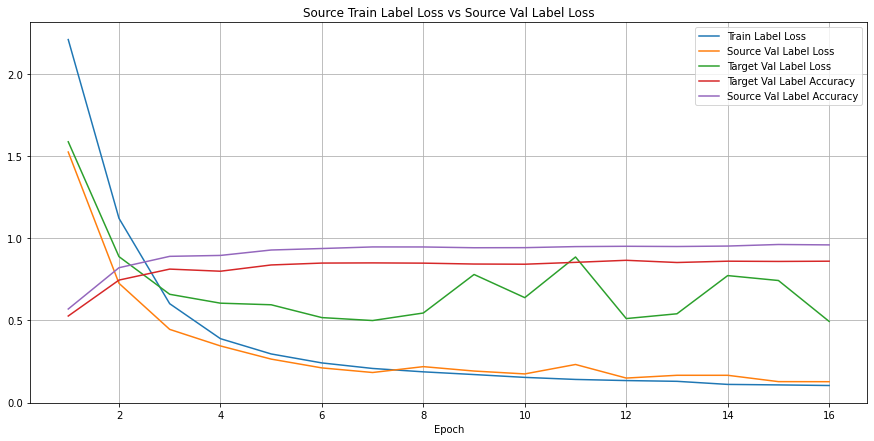

In [16]:
get_loss_curve(experiment)

<AxesSubplot:title={'center':'Results'}>

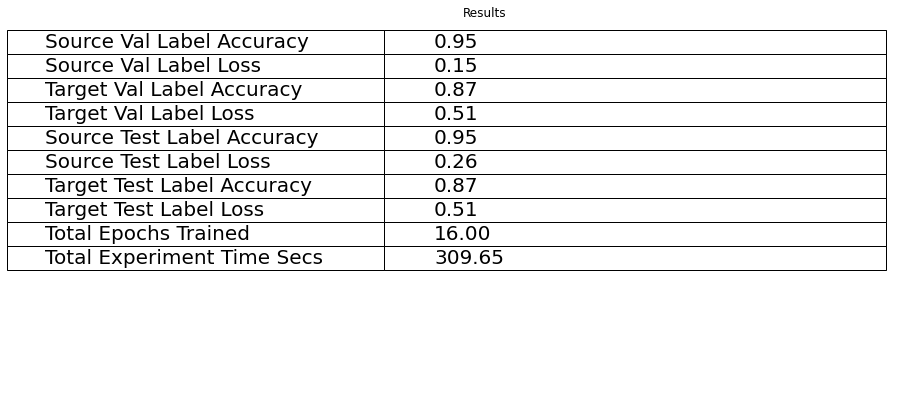

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Accuracy'}, xlabel='domain'>

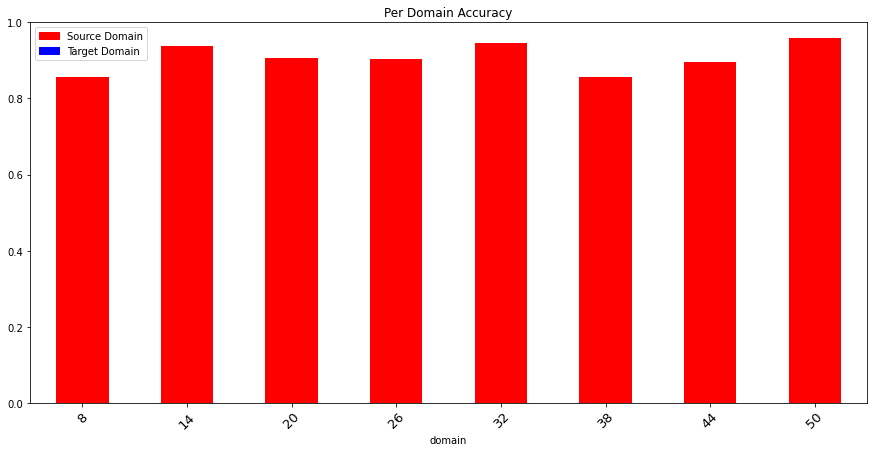

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9497135416666667 Target Test Label Accuracy: 0.8655208333333333
Source Val Label Accuracy: 0.9505208333333334 Target Val Label Accuracy: 0.865234375


In [20]:
json.dumps(experiment)

'{"experiment_name": "cnn_3:oracle.run1.framed-oracle.run2.framed", "parameters": {"experiment_name": "cnn_3:oracle.run1.framed-oracle.run2.framed", "labels": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "domains_source": [8, 32, 50, 14, 20, 26, 38, 44], "domains_target": [8, 32, 50, 14, 20, 26, 38, 44], "pickle_name_source": "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl", "pickle_name_target": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl", "device": "cuda", "lr": 0.0001, "batch_size": 128, "normalize_source": false, "normalize_target": false, "num_examples_per_domain_per_label_source": -1, "num_examples_per_domain_per_label_target": -1, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d